## 결정트리모델

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier(random_state=156)

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target,
                                                    test_size=0.2, random_state=11)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

Feature importances :
[0.025 0.    0.555 0.42 ]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


<Axes: >

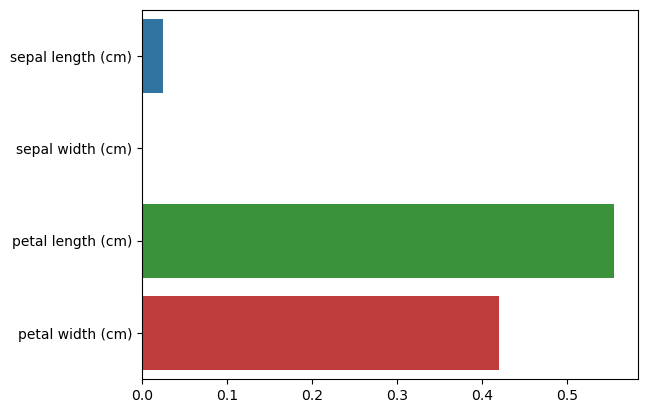

In [2]:
import seaborn as sns
import numpy as np
%matplotlib inline

print('Feature importances :\n{0}'.format(np.round(dt_clf.feature_importances_, 3)))

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))
    
sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

### 결정트리 과적합

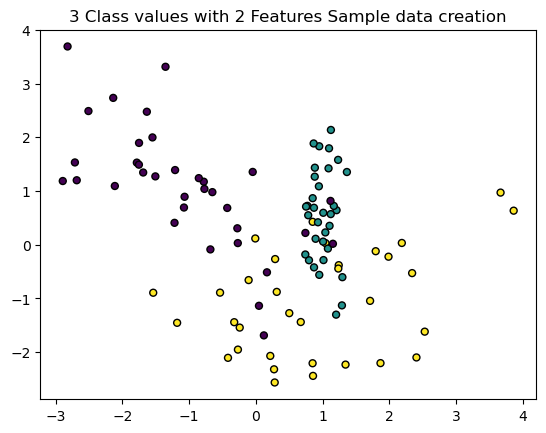

In [3]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('3 Class values with 2 Features Sample data creation')

X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                           n_classes=3, n_clusters_per_class=1, random_state=0)

plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, edgecolor='k')

## 결정트리 실습

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+',
                              header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출 :', feature_name[:10])

전체 피처명에서 10개만 추출 : ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [5]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()      

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [6]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                              'dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1])
                                                                                if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [7]:
import pandas as pd

def get_human_dataset():
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+',
                              header=None, names=['column_index', 'column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action']) 
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action']) 
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [8]:
print('## 학습 피처 데이터셋 inf()')
print(X_train.info())

## 학습 피처 데이터셋 inf()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [9]:
print(y_train['action'].value_counts())

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도 : {0:.4f}'.format(accuracy))

print('DecisionTreeClassifier 기본 하이퍼 파라미터 :\n', dt_clf.get_params())

결정 트리 예측 정확도 : 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터 :
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [11]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split' : [16]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터 :', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8549
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [12]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [13]:
max_depths = [6, 8, 10, 12, 16, 20, 24]

for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도 : {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도 : 0.8551
max_depth = 8 정확도 : 0.8717
max_depth = 10 정확도 : 0.8599
max_depth = 12 정확도 : 0.8571
max_depth = 16 정확도 : 0.8599
max_depth = 20 정확도 : 0.8565
max_depth = 24 정확도 : 0.8565


In [14]:
params = {
    'max_depth' : [8, 12, 16, 20],
    'min_samples_split' : [16, 20],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터 :', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8549
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [15]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도 : {0:.4f}'.format(accuracy))

결정 트리 예측 정확도 : 0.8717


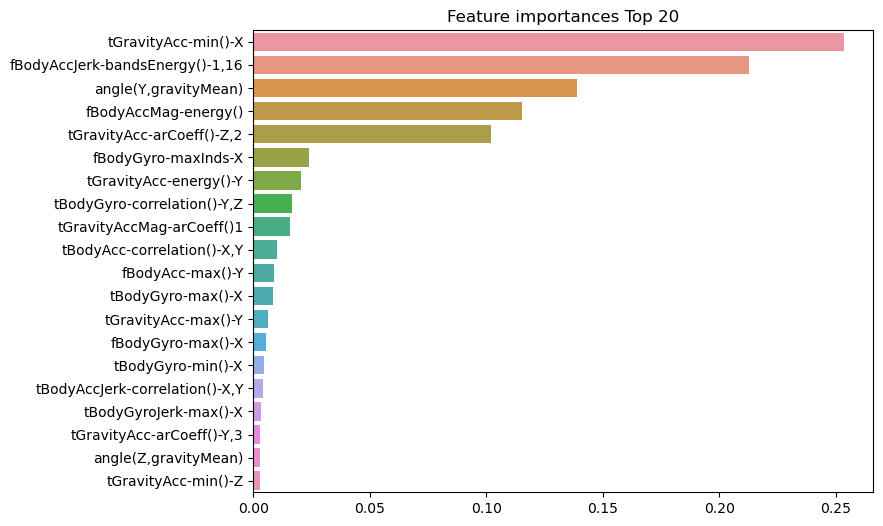

In [16]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## 보팅 분류기

In [17]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [18]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    test_size=0.2, random_state=156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도 : 0.9561
LogisticRegression 정확도 : 0.9474
KNeighborsClassifier 정확도 : 0.9386


## 랜덤포레스트

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9196


In [20]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16],
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터 :\n', grid_cv.best_params_)
print('최고 예측 정확도 :{0:.4f}'.format(grid_cv.best_score_))


/Users/heeju/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/heeju/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/heeju/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/heeju/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

최적 하이퍼 파라미터 :
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도 :0.9165


In [21]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16,
                                 min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9260


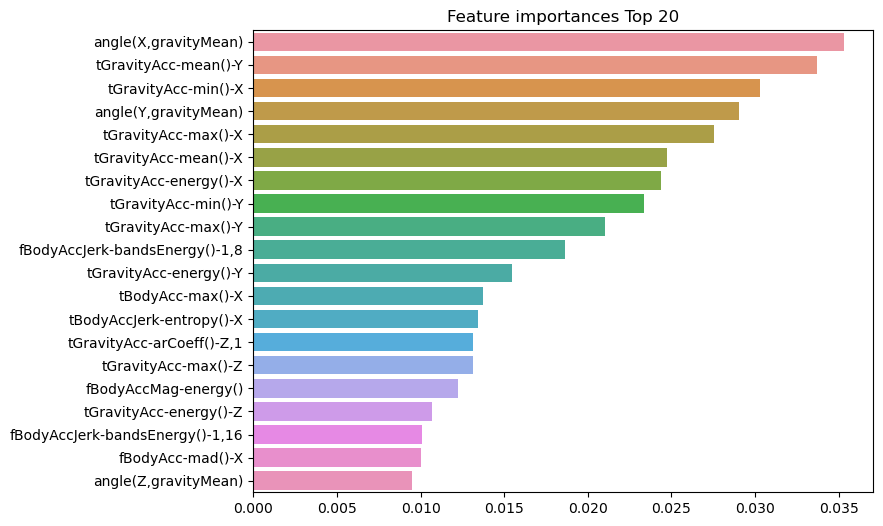

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## GBM

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))
print('GBM 수행시간 : {0:.1f}초'.format(time.time() - start_time))

GBM 정확도 : 0.9386
GBM 수행시간 : 576.2초


## XGBoost

In [24]:
import xgboost as xgb
from xgboost import XGBClassifier

In [25]:
print(xgb.__version__)

1.7.3


In [27]:
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target
cancer_df=pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [29]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [30]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [33]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [34]:
params = {'max_depth' : 3,
          'eta' : 0.05,
          'objective' : 'binary:logistic',
          'eval_metrix' : 'logloss'
         }
num_rounds = 400

In [35]:
eval_list = [(dtr, 'train'), (dval, 'eval')]
xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round=num_rounds, \
                      early_stopping_rounds = 50, evals=eval_list)

[20:43:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "eval_metrix" } are not used.

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	

In [37]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시 :', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시 : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f},\
    F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [41]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도 : 0.9561, 정밀도 : 0.9615, 재현율 : 0.9740,    F1 : 0.9677, AUC : 0.9937


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

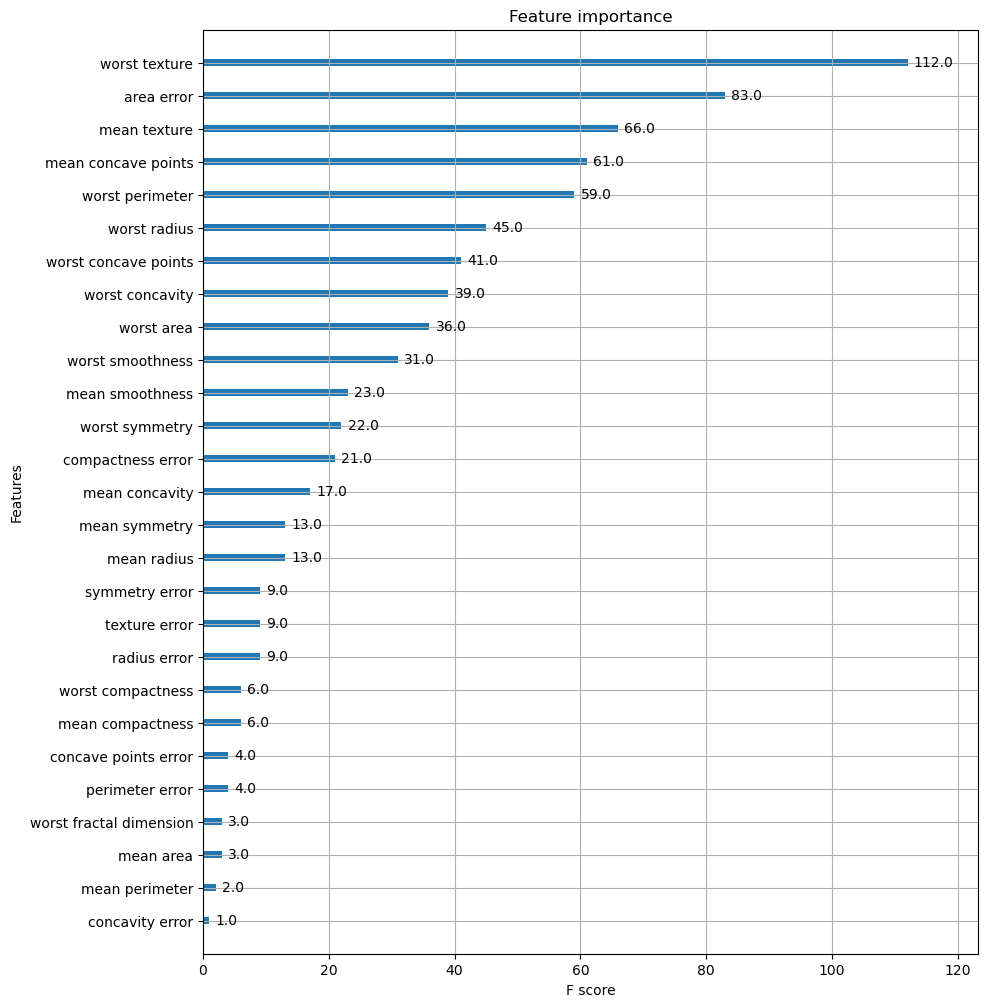

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

In [46]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3,
                            eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [47]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도 : 0.9649, 정밀도 : 0.9620, 재현율 : 0.9870,    F1 : 0.9744, AUC : 0.9954


In [48]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals=[(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)
ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [49]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도 : 0.9561, 정밀도 : 0.9615, 재현율 : 0.9740,    F1 : 0.9677, AUC : 0.9933


In [50]:
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='logloss',
                eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

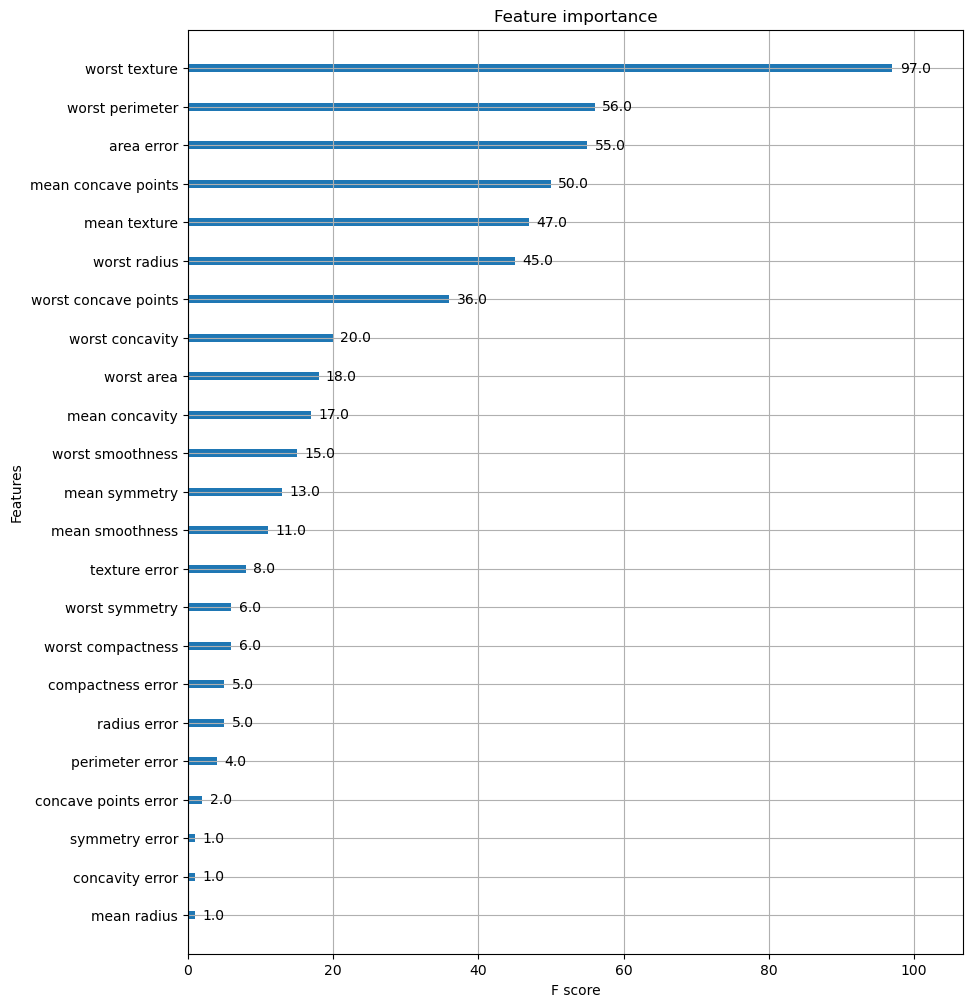

In [51]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)

## LightGBM

In [74]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

evals=[(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, eval_metric='logloss',
                 eval_set=evals)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613692 -> initscore=0.462858
[LightGBM] [Info] Start training from score 0.462858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [61]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도 : 0.9561, 정밀도 : 0.9615, 재현율 : 0.9740,    F1 : 0.9677, AUC : 0.9923


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

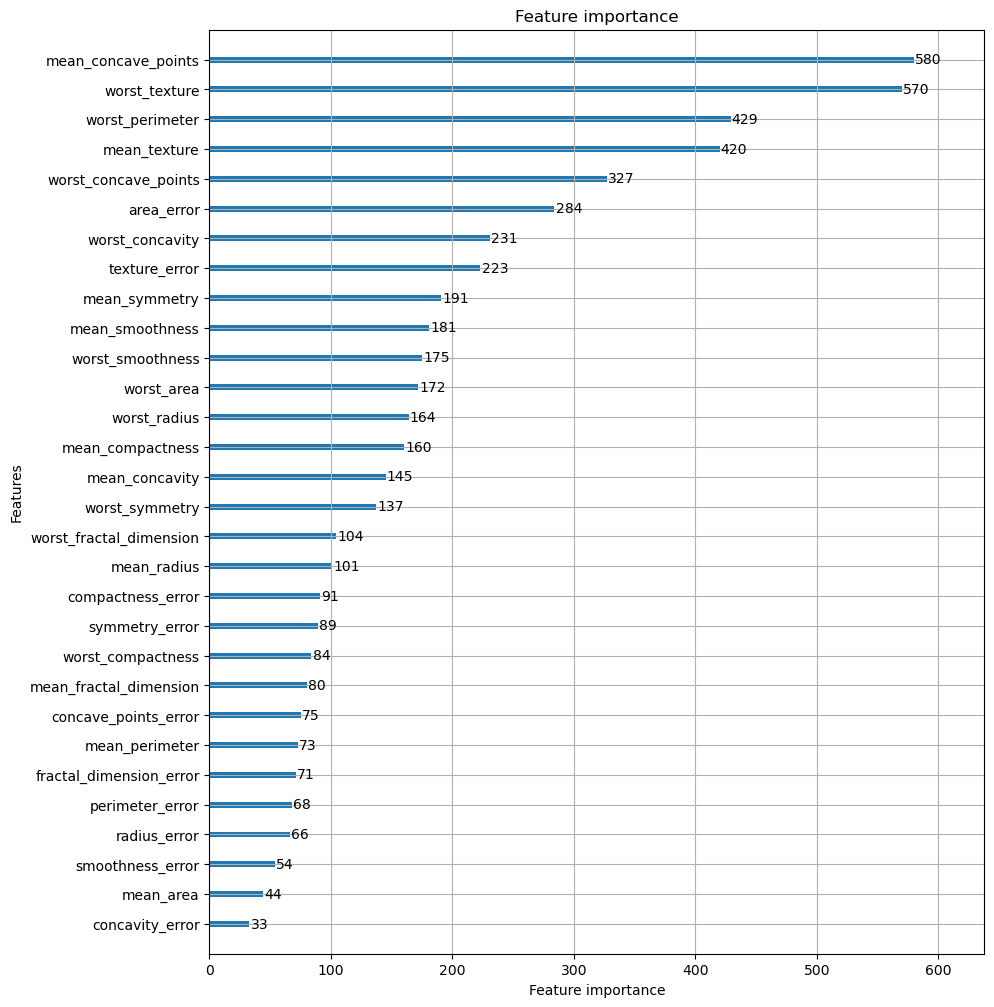

In [65]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

## 베이지안 최적화

In [70]:
# pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 19.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [71]:
from hyperopt import hp

search_space = {'x' : hp.quniform('x', -10, 10, 1), 'y' : hp.quniform('y', -15, 15, 1)}

In [72]:
from hyperopt import STATUS_OK

def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

In [75]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()

best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5,
               trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best :', best_01)

100%|██████████████████████| 5/5 [00:00<00:00, 478.29trial/s, best loss: -224.0]
best : {'x': -4.0, 'y': 12.0}


In [76]:
trial_val = Trials()

best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20,
               trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best :', best_02)

100%|████████████████████| 20/20 [00:00<00:00, 783.18trial/s, best loss: -296.0]
best : {'x': 2.0, 'y': 15.0}


In [77]:
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [78]:
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [79]:
import pandas as pd

losses = [loss_dict['loss'] for loss_dict in trial_val.results]

result_df = pd.DataFrame({'x' : trial_val.vals['x'], 'y' : trial_val.vals['y'], 'losses' : losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [81]:
from hyperopt import hp

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight' : hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
                   }

In [82]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    return {'loss' : -1 * np.mean(accuracy), 'status' : STATUS_OK}

In [83]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best :', best)

100%|████████| 50/50 [00:05<00:00,  9.63trial/s, best loss: -0.9692401533635412]
best : {'colsample_bytree': 0.548301545497125, 'learning_rate': 0.1840281762576621, 'max_depth': 18.0, 'min_child_weight': 2.0}


In [85]:
print('colsample_bytree : {0}, learning_rate : {1}, max_depth : {2}, min_child_weight : {3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5), int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree : 0.5483, learning_rate : 0.18403, max_depth : 18, min_child_weight : 2


In [86]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )
eval = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
                        
get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.54472	validation_1-logloss:0.58675
[1]	validation_0-logloss:0.44155	validation_1-logloss:0.52577
[2]	validation_0-logloss:0.36542	validation_1-logloss:0.48906
[3]	validation_0-logloss:0.30756	validation_1-logloss:0.45704
[4]	validation_0-logloss:0.26142	validation_1-logloss:0.41671
[5]	validation_0-logloss:0.22616	validation_1-logloss:0.39605
[6]	validation_0-logloss:0.19465	validation_1-logloss:0.37095
[7]	validation_0-logloss:0.16951	validation_1-logloss:0.36066
[8]	validation_0-logloss:0.14718	validation_1-logloss:0.34686
[9]	validation_0-logloss:0.13006	validation_1-logloss:0.33716
[10]	validation_0-logloss:0.11635	validation_1-logloss:0.32332
[11]	validation_0-logloss:0.10455	validation_1-logloss:0.32074
[12]	validation_0-logloss:0.09388	validation_1-logloss:0.31916
[13]	validation_0-logloss:0.08434	validation_1-logloss:0.30987
[14]	validation_0-logloss:0.07702	validation_1-logloss:0.30469
[15]	validation_0-logloss:0.07144	validation_1-logloss:0.30293
[1

## 산탄데르 고객 만족 예측 실습

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
cust_df = pd.read_csv('./train_santander.csv', encoding='latin-1')
print('dataset shape :', cust_df.shape)
cust_df.head(3)

dataset shape : (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [4]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [6]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
print(cust_df.var3.value_counts()[:10])

var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: count, dtype: int64


In [8]:
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape : {0}'.format(X_features.shape))

피처 데이터 shape : (76020, 369)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape : {0}, 테스트 세트 Shape : {1}'.format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts() / test_cnt)

학습 세트 Shape : (60816, 369), 테스트 세트 Shape : (15204, 369)
 학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [10]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

In [13]:
from hyperopt import hp

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)}

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'])
    
    roc_auc_list = []
    
    kf = KFold(n_splits=3)
    
    for tr_index, val_index in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                    eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    return -1 * np.mean(roc_auc_list)

In [18]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best :', best)

[0]	validation_0-auc:0.73641	validation_1-auc:0.69861                           
[1]	validation_0-auc:0.75284	validation_1-auc:0.71875                           
[2]	validation_0-auc:0.81276	validation_1-auc:0.78335                           
[3]	validation_0-auc:0.82545	validation_1-auc:0.79690                           
[4]	validation_0-auc:0.83346	validation_1-auc:0.80340                           
[5]	validation_0-auc:0.83938	validation_1-auc:0.81157                           
[6]	validation_0-auc:0.83511	validation_1-auc:0.80456                           
[7]	validation_0-auc:0.84044	validation_1-auc:0.81013                           
[8]	validation_0-auc:0.83842	validation_1-auc:0.80757                           
[9]	validation_0-auc:0.83590	validation_1-auc:0.80661                           
[10]	validation_0-auc:0.84039	validation_1-auc:0.81095                          
[11]	validation_0-auc:0.84409	validation_1-auc:0.81470                          
[12]	validation_0-auc:0.8479

In [19]:
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']),
                        min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'], 5)
                       )

xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
            eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.73335	validation_1-auc:0.71651
[1]	validation_0-auc:0.75752	validation_1-auc:0.72910
[2]	validation_0-auc:0.81737	validation_1-auc:0.79861
[3]	validation_0-auc:0.82980	validation_1-auc:0.81081
[4]	validation_0-auc:0.83890	validation_1-auc:0.81679
[5]	validation_0-auc:0.84152	validation_1-auc:0.81826
[6]	validation_0-auc:0.83828	validation_1-auc:0.81667
[7]	validation_0-auc:0.84259	validation_1-auc:0.81949
[8]	validation_0-auc:0.84295	validation_1-auc:0.81607
[9]	validation_0-auc:0.84051	validation_1-auc:0.81218
[10]	validation_0-auc:0.84692	validation_1-auc:0.81862
[11]	validation_0-auc:0.84980	validation_1-auc:0.82227
[12]	validation_0-auc:0.85326	validation_1-auc:0.82652
[13]	validation_0-auc:0.85186	validation_1-auc:0.82427
[14]	validation_0-auc:0.85543	validation_1-auc:0.82727
[15]	validation_0-auc:0.85830	validation_1-auc:0.83023
[16]	validation_0-auc:0.85930	validation_1-auc:0.83045
[17]	validation_0-auc:0.86011	validation_1-auc:0.83259
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

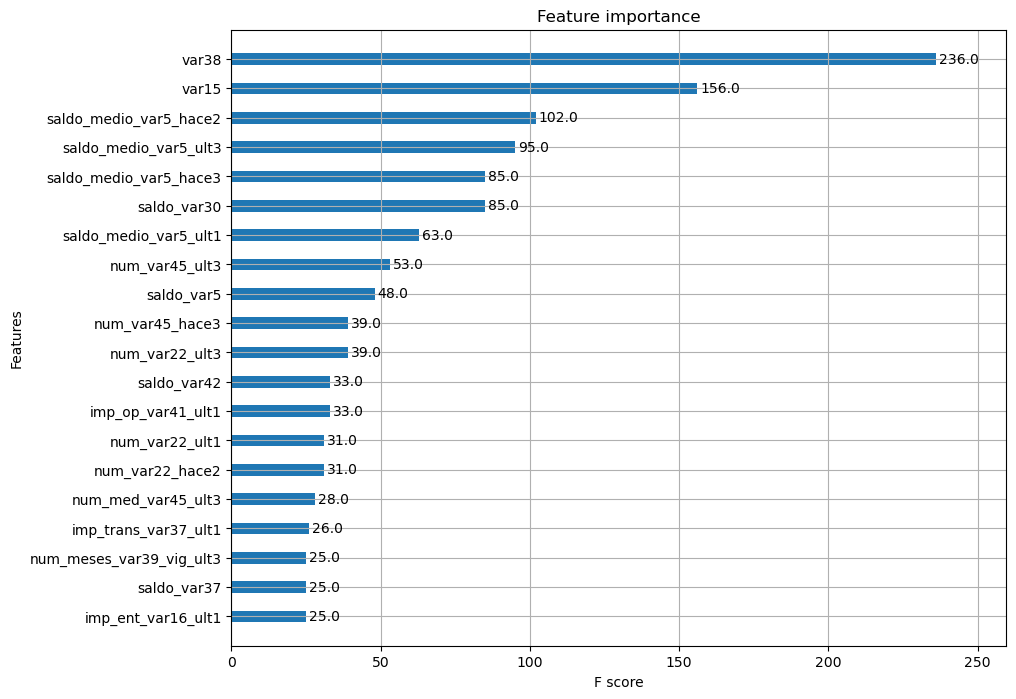

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [21]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_metric='auc', eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
ROC AUC : 0.8134


In [22]:
lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples' : hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample' : hp.uniform('subsample', 0.7, 1),
                     'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)
                    }

In [23]:
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators=100, 
                              num_leaves=int(search_space['num_leaves']),
                              max_depth=int(search_space['max_depth']),
                              min_child_samples=int(search_space['min_child_samples']),
                              subsample=search_space['subsample'],
                              learning_rate=search_space['learning_rate'])
    
    roc_auc_list = []
    
    kf = KFold(n_splits=3)
    
    for tr_index, val_index in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        lgbm_clf.fit(X_tr, y_tr, eval_metric='auc',
                    eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    return -1 * np.mean(roc_auc_list)

In [24]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, 
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best :', best)

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965           
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827                                              
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872 
[LightGBM] [Info] Start training from score -3.205872                           
[LightGBM] [Info] Number of positive: 1609, number of negative: 38935           
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13008               

In [25]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=round(best['subsample'], 5),
                          learning_rate=round(best['learning_rate'], 5)
                         )

lgbm_clf.fit(X_tr, y_tr, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12898
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
ROC AUC : 0.8443


## 캐글 신용카드 사기 검출 실습

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [28]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [30]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [ ]:
def get_